<a href="https://colab.research.google.com/github/charleswongzx/pytorch-fashionmnist/blob/master/pytorch_fasionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple neural network for FashionMNIST

## Important Imports

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.nn.functional as F 
import torch.optim as optim
import numpy as np
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline

## Define Hyperparameters

In [0]:
batch_train = 128
batch_val = 128
epochs = 50

## Loading Data
Here we make use of Torch's dataset and dataloader class for easy data manipulation and batching.
As instructed, we are splitting the data into an 80:20 train/test split, though this is not generally advised. Training the model on a loss function without a separate validation set increases likelihood of the model overfitting to that set, artificially inflating accuracy.

In [0]:
fashion_mnist_data = datasets.FashionMNIST("../data", train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))

dataset_size = len(fashion_mnist_data)
indices = [i for i in range(dataset_size)]

np.random.shuffle(indices)

split = int(np.floor(0.2 * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(fashion_mnist_data, batch_size=batch_train, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(fashion_mnist_data, batch_size=batch_val, sampler=valid_sampler)

## Defining Our Model
As instructed, our model is as follows:

* l1: fully connected layer with 300 neurons, followed by a relu
* l2: fully connected layer with 100 neurons, followed by a relu
* l3: fully connected layer with 10 neurons



In [0]:
class SimpleNN(nn.Module):
    def __init__(self, input_dims):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(input_dims, 300)
        self.l2 = nn.Linear(300, 100)
        self.l3 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return nn.functional.log_softmax(x, dim=1)

## Define Training, Validation and Test Sequences
Below is a modified version of the example in pytorch/examples. Here, we add a record of correctly predicted samples, train + val loss, as well as saving best weights over each epoch.

In [0]:
def train(model, device, train_loader, optimizer):
    model.train(True)

    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction="mean")
        batch_loss = F.nll_loss(output, target, reduction="sum").item()
        train_loss += batch_loss
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

    num_samples = len(train_loader.sampler)
    avg_train_loss = train_loss/num_samples

    print('train_loss: {:.4f}, train_accuracy: {}/{} ({:.3f})'.format(
        avg_train_loss, correct, num_samples,
        correct / num_samples))

    return avg_train_loss, correct/num_samples


def validation(model, device, valid_loader):
    model.train(False)

    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_samples = len(valid_loader.sampler)
    avg_valid_loss = val_loss/num_samples

    print('val_loss: {:.4f}, val_accuracy: {}/{} ({:.3f})'.format(
        avg_valid_loss, correct, num_samples,
        correct / num_samples))

    return avg_valid_loss, correct/num_samples


def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    clf_matrix = torch.zeros(10, 10)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
                clf_matrix[t.long(), p.long()] += 1

    num_samples = float(len(test_loader.sampler))
    avg_test_loss = test_loss/num_samples

    print('test_loss: {:.4f}, test_accuracy: {}/{} ({:.3f})\n'.format(
        avg_test_loss, correct, num_samples,
        correct / num_samples))

    clf_report = clf_matrix.diag()/clf_matrix.sum(1)

    return avg_test_loss, correct/num_samples, clf_report


## Training the Model

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")

print("Available device = ", device)
model = SimpleNN(input_dims=28*28).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

loss_hist = []
acc_hist = []

for epoch in range(epochs):
  print('Epoch: {}/{}'.format(epoch, epochs))
  tr_loss, tr_acc = train(model, device, train_loader, optimizer)
  val_loss, val_acc = validation(model, device, valid_loader)

  if len(loss_hist)> 0:
    if val_loss < min(loss_hist, key = lambda t: t[1])[1]:
      print('Best loss recorded, saving weights...')
      torch.save(model.state_dict(), 'fashionmnist.pt')

  loss_hist.append((tr_loss, val_loss))
  acc_hist.append((tr_acc, val_acc))
  print("--------------------------------")


Available device =  cuda
Epoch: 0/50
train_loss: 1.9384, train_accuracy: 21392/48000 (0.446)
val_loss: 1.3863, val_accuracy: 6999/12000 (0.583)
--------------------------------
Epoch: 1/50
train_loss: 1.0866, train_accuracy: 30624/48000 (0.638)
val_loss: 0.9002, val_accuracy: 8109/12000 (0.676)
Best loss recorded, saving weights...
--------------------------------
Epoch: 2/50
train_loss: 0.8214, train_accuracy: 33418/48000 (0.696)
val_loss: 0.7606, val_accuracy: 8587/12000 (0.716)
Best loss recorded, saving weights...
--------------------------------
Epoch: 3/50
train_loss: 0.7237, train_accuracy: 35309/48000 (0.736)
val_loss: 0.6922, val_accuracy: 8968/12000 (0.747)
Best loss recorded, saving weights...
--------------------------------
Epoch: 4/50
train_loss: 0.6638, train_accuracy: 36604/48000 (0.763)
val_loss: 0.6389, val_accuracy: 9301/12000 (0.775)
Best loss recorded, saving weights...
--------------------------------
Epoch: 5/50
train_loss: 0.6197, train_accuracy: 37541/48000 (0.

## Analysing Train/Val Accuracy and Loss

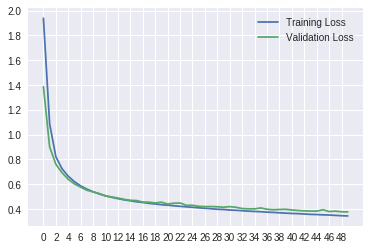

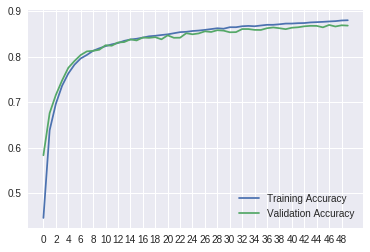

In [0]:
# Plot training and validation loss
plt.figure(1)
x1 = [i for i in range(0, len(loss_hist), 2)]
plt.plot([i[0] for i in loss_hist], label = "Training Loss")
plt.plot([i[1] for i in loss_hist], label = "Validation Loss")
plt.xticks(x1)
plt.legend()


# Plot training and validation accuracy
plt.figure(2)
x2 = [i for i in range(0, len(loss_hist), 2)]
plt.plot([i[0] for i in acc_hist], label = "Training Accuracy")
plt.plot([i[1] for i in acc_hist], label = "Validation Accuracy")
plt.xticks(x2)
plt.legend()

plt.show()

## Evaluating Model on Test Set

In [0]:
best_model = SimpleNN(input_dims=28*28).to(device)
best_model.load_state_dict(torch.load('fashionmnist.pt'))

test_loss, test_acc, clf_report = test(best_model, device, valid_loader)

test_loss: 0.3513, test_accuracy: 10525/12000.0 (0.877)



## Class-wise Accuracy

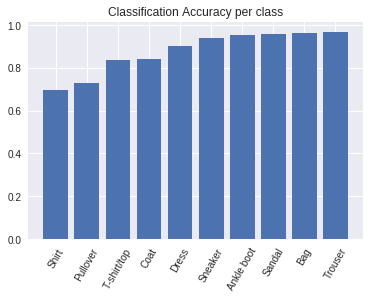

Average accuracy over classes: 0.8785332202911377


In [0]:
CLASS_CLOTHING = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

# Create dictionary of class and accuracy
class_wise_acc = dict()
total_acc = 0
for i in range(len(clf_report)):
    class_wise_acc[CLASS_CLOTHING[i]] = clf_report[i].item()
    total_acc += clf_report[i].item()

class_wise_acc = dict(sorted(class_wise_acc.items(), key=lambda x: x[1]))
plt.bar(range(len(class_wise_acc)), list(class_wise_acc.values()), align='center')
plt.xticks(range(len(class_wise_acc)), list(class_wise_acc.keys()), rotation = 60)
plt.title("Classification Accuracy per class")
plt.show()

print('Average accuracy over classes: {}'.format(total_acc/10))